In [1]:
# the list of files need to be import
import talib as ta
import pandas as pd
import mplfinance as mpf
import numpy as np
import uuid
import os
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,random_split,Dataset
from torchvision.transforms import transforms as T
from sklearn.model_selection import train_test_split
from torch import optim
from PIL import Image
import torchvision.models as models
from tqdm.notebook import tqdm
from torchvision.datasets import ImageFolder
pd.options.mode.chained_assignment = None

In [2]:
# read the csv file and process to get all indicators we need
candle_data_2000=pd.read_csv("SPY_new.csv", header=0, infer_datetime_format=True, parse_dates=True)
candle_data_2000['RSI'] = ta.RSI(candle_data_2000.Close, timeperiod=20)
candle_data_2000['CCI'] = ta.CCI(candle_data_2000.High, candle_data_2000.Low, candle_data_2000.Close, timeperiod=20)
candle_data_2000['WILLR'] = ta.WILLR(candle_data_2000.High, candle_data_2000.Low, candle_data_2000.Close, timeperiod=20)
candle_data_2000=candle_data_2000.drop(["Adj Close"], axis=1)
candle_data_2000['Date']=pd.to_datetime(candle_data_2000['Date']) 

In [3]:
candle_data_2000

,Date,Open,High,Low,Close,Volume,RSI,CCI,WILLR
0,1995-01-03,45.703125,45.843750,45.687500,45.781250,324300,NaN,NaN,NaN
1,1995-01-04,45.984375,46.000000,45.750000,46.000000,351800,NaN,NaN,NaN
2,1995-01-05,46.031250,46.109375,45.953125,46.000000,89800,NaN,NaN,NaN
3,1995-01-06,46.093750,46.250000,45.906250,46.046875,448400,NaN,NaN,NaN
4,1995-01-09,46.031250,46.093750,46.000000,46.093750,36800,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
6288,2019-12-23,321.589996,321.649994,321.059998,321.220001,52990000,70.877217,127.122006,-5.053910
6289,2019-12-24,321.470001,321.519989,320.899994,321.230011,20270000,70.890745,108.966115,-4.986457
6290,2019-12-26,321.649994,322.950012,321.640015,322.940002,30911200,73.134830,118.875674,-0.063274
6291,2019-12-27,323.739990,323.799988,322.279999,322.859985,42528800,72.858167,111.851018,-5.638896


In [4]:
# create the monthly candle stick graphs for each year
path_to_images="./images/"

candle_data_2000=candle_data_2000.set_index('Date')
result=pd.DataFrame(columns=['id','target'])

#----------Run the following code to form monthly candle stick graphs for each year--------
years=[1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]
# dict_={'Jun':30,'Jul':31,'Aug':31,'Sep':30,'Oct':31,'Nov':30,'Dec':31}
# dict_={'Jan':29}
dict_={'Jan':31,'Feb':28,'Mar':31,'Apr':30,'May':31,'Jun':30,'Jul':31,'Aug':31,'Sep':30,'Oct':31,'Nov':30,'Dec':31}

for year in years:
    for key,value in dict_.items():
        start_date='{}-{}-01'.format(year,key)
        end_date='{}-{}-{}'.format(year,key,value)
        candle_month=candle_data_2000.loc[start_date:end_date]
        
        close=candle_month.Close
        n=candle_month.shape[0]
        if close[n-1]>=close[n-2]:
            target=1
        else:
            target=0
        candle_month['RSI'] = (candle_month['RSI'] - candle_month['RSI'].min()) / (candle_month['RSI'].max() - candle_month['RSI'].min())
        candle_month['CCI'] = (candle_month['CCI'] - candle_month['CCI'].min()) / (candle_month['CCI'].max() - candle_month['CCI'].min())
        candle_month['WILLR'] = (candle_month['WILLR'] - candle_month['WILLR'].min()) / (candle_month['WILLR'].max() - candle_month['WILLR'].min())
        fig_id_=str(uuid.uuid4())
        result=result.append({"id":fig_id_+".png","target":target}, ignore_index=True)
        
        save = dict(fname=path_to_images+fig_id_+".png",bbox_inches='tight',pad_inches=0)
        apdict = [mpf.make_addplot(candle_month["RSI"], color='r',secondary_y=True),
                 mpf.make_addplot(candle_month["CCI"], color='g', secondary_y=True),
                 mpf.make_addplot(candle_month["WILLR"], color='b', secondary_y=True)]
#         apdict = mpf.make_addplot(candle_month["RSI"])
        # addplot=apdict
        mpf.plot(candle_month[-n:], type="candlestick",volume=True,mav=(3, 6, 9),figratio=(10,10),ylabel='',addplot=apdict,show_nontrading =False,savefig=save )
        fig_id_=""
        target=""
        del candle_month
# del result

#------------Saving the results in .csv------------
#---------------Must be run after the generation of all candle stick images
result.to_csv("results.csv", index=False)

In [5]:
# read the csv
df = pd.read_csv("results.csv")
# split into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, shuffle=True)

In [6]:
val_df.shape, train_df.shape

((60, 2), (240, 2))

In [7]:
# create image dataset
class myDataset(Dataset):
    def __init__(self, df, transform=None):
        self.transform = transform
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        image_path = './images'
        path = os.path.join(image_path,self.df.iloc[index].id)
        label = self.df.iloc[index].target
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ymin = 0
        ymax = 400
        xmin = 85
        xmax = 500
        img = img[ymin:ymax,xmin:xmax,:]
        img = Image.fromarray(np.uint8(img))
        if self.transform is not None:
            img = self.transform(img)
        return img,label

In [8]:
# make general transformation of the original images
image_length = 224
val_transform = T.Compose([T.Resize((image_length,image_length)),
                    T.ToTensor(),
                    T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]
                         )
train_transform=T.Compose([
#                     T.RandomResizedCrop(image_length),
#                     T.RandomHorizontalFlip(),
#                     T.RandomCrop(224, padding=2, padding_mode='reflect'),
#                     T.RandomRotation(degrees=20),
                    
                    T.Resize((image_length,image_length)),
                    T.ToTensor(),
                    T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]
                         )

In [9]:
# the transformation when we apply LSTM only
image_length = 224
val_transform_gray = T.Compose([T.Grayscale(num_output_channels=1),
                    T.Resize((image_length,image_length)),
                    T.ToTensor(),
                    T.Normalize(mean=[0.5],std=[0.5])]
                         )
train_transform_gray=T.Compose([T.Grayscale(num_output_channels=1),                  
                    T.Resize((image_length,image_length)),
                    T.ToTensor(),
                    T.Normalize(mean=[0.5],std=[0.5])]
                         )

In [10]:
# create dataset and load data
train_dataset = myDataset(train_df,train_transform)
val_dataset = myDataset(val_df,val_transform)
train_dataloader = DataLoader(train_dataset,batch_size = 16)
val_dataloader = DataLoader(val_dataset,batch_size = 16)
len(train_dataset), len(val_dataset)

(240, 60)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


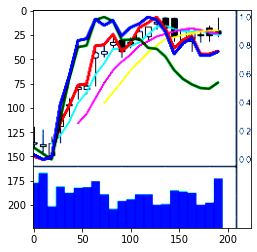

In [11]:
# example of our candle stick images
img,label = train_dataset.__getitem__(0)
plt.imshow(img.permute(1,2,0))

In [13]:
# the googlenet model
class GoogleNet(nn.Module):
    def __init__(self, num_classes=2, pretrained = True):
        super(GoogleNet, self).__init__()
        self.net = models.googlenet(pretrained=pretrained)
        num_ftrs = self.net.fc.in_features
        self.net.fc = nn.Sequential(
            nn.Linear(num_ftrs, num_classes, bias=True),
        )

    def forward(self, x):
        return self.net(x)

In [14]:
# the CNN model
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=1, padding=1),   # 224 * 244 * 64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),                                   
            nn.MaxPool2d(4, 4),                         # 56 * 56 * 64

            nn.Conv2d(64, 128, 3, stride=1, padding=1),    # 56 * 56* 128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4,4),                          # 14 * 14* 128

            nn.Conv2d(128, 256, 3, stride=1, padding=1),   # 14*14*256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),                        # 7*7*256
            
            nn.Flatten(),
            nn.Linear(7*7*256, 512),
            nn.ReLU(True),
            nn.Linear(512, 128),
            nn.ReLU(True),
            nn.Linear(128, num_classes))

            
    def forward(self, x):
        return self.network(x)
        

In [15]:
# the Resnet model
class ResNet(nn.Module):
    def __init__(self, num_classes=2, pretrained = True):
        super(ResNet, self).__init__()
        self.net = models.resnet50(pretrained=pretrained)
        num_ftrs = self.net.fc.in_features
        self.net.fc = nn.Sequential(
            nn.Linear(num_ftrs, num_classes),
        )

    def forward(self, x):
        return self.net(x)

In [16]:
# the CNNwith LSTM model
class CNNwithLSTM(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNwithLSTM, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2)))
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2)))
        
        self.lstm = nn.LSTM(64, 128, 2, batch_first=True)
        self.fc = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.layer1(x)
        #x = x.permute(0, 3, 1, 2)
        x = self.layer2(x)
        x = x.view(x.size(0), x.size(1), -1)
        x = x.permute(0,2,1)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x

In [17]:
# LSTM model
class LSTMnet(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_layer, n_class):
        super(LSTMnet, self).__init__()
        self.n_layer = n_layer
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(in_dim, hidden_dim, n_layer, batch_first=True)
        self.linear = nn.Linear(hidden_dim, n_class)
 
    def forward(self, x):                  
        out, _ = self.lstm(x)              
        out = out[:, -1, :]                                           
        out = self.linear(out)             
        return out

In [18]:
# VGGnet model
class VGGNet(nn.Module):
    def __init__(self, num_classes=2, pretrained = True):
        super(VGGNet, self).__init__()
        net = models.vgg16_bn(pretrained=pretrained)
#         pre=torch.load('vgg16_bn-6c64b313.pth')
#         net.load_state_dict(pre)
        net.classifier = nn.Sequential()
        self.features = net
        self.classifier = nn.Sequential(
                nn.Linear(512 * 7 * 7, 512),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(512, 128),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [19]:
# get the accuracy between two batchs
def accuracy(output, labels):
    pred = torch.max(output, dim=1)[1]
    return (pred == labels).sum().item()/ len(labels)

In [20]:
# for each epoch we train the model
def train_epoch(model, train_dataloader, optimizer, loss_func, train_loss_list, train_accuracy_list,lstm=False):
    train_loss = 0.
    train_acc = 0.
    model.train()
    for batch_x, batch_y in tqdm(train_dataloader):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        if lstm:
            batch_x = batch_x.reshape(-1,224,224)
        out = model(batch_x)
        loss = loss_func(out, batch_y)
        train_loss += loss.item()
        train_acc += accuracy(out, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('Train Loss: {:.6f}, Acc: {:.6f}'.format(train_loss / (len(
    train_dataloader)), train_acc / (len(train_dataloader))))
    train_loss_list.append(train_loss / (len(train_dataloader)))
    train_accuracy_list.append(train_acc / (len(train_dataloader)))
    return train_loss_list, train_accuracy_list

In [21]:
# for each epoch we validate and save the best weight
def val_epoch(model, test_dataloader, optimizer, loss_func, test_loss_list, test_accuracy_list, best_test_accuracy, weight_path,lstm=False):
    model.eval()
    with torch.no_grad():
        test_loss = 0.
        test_acc = 0.
        for batch_x, batch_y in tqdm(test_dataloader):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            if lstm:
                batch_x = batch_x.reshape(-1,224,224)
            out = model(batch_x)
            loss = loss_func(out, batch_y)
            test_loss += loss.item()
            test_acc += accuracy(out, batch_y)
        print('Test Loss: {:.6f}, Acc: {:.6f}'.format(test_loss / (len(
        test_dataloader)), test_acc / (len(test_dataloader))))
        test_loss_list.append(test_loss / (len(test_dataloader)))
        test_accuracy_list.append(test_acc / (len(test_dataloader)))
        if (test_acc / (len(test_dataloader))) > best_test_accuracy:
            best_test_accuracy = test_acc / (len(test_dataloader))
            torch.save(model.state_dict(),weight_path)
    return test_loss_list, test_accuracy_list, best_test_accuracy

In [22]:
# print(CNNwithLSTM())

In [23]:
# after we train every epoch, we test using our validation set
def test_result(model, test_dataloader, weight_path):
    model.eval()
    with torch.no_grad():
        model.load_state_dict(torch.load(weight_path))
        test_acc = 0.
        for batch_x, batch_y in tqdm(test_dataloader):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            out = model(batch_x)
            test_acc += accuracy(out, batch_y)
        print('Test Acc: {:.6f}'.format(test_acc / (len(test_dataloader))))

In [26]:
epoch = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weight_path = "cnn_best_weight.pth"

model = VGGNet(pretrained=True).to(device)
# model = ResNet(pretrained=True).to(device)
# model = LSTMnet(224, 128, 2, 2).to(device)
# model = CNNwithLSTM().to(device)
# model = GoogleNet().to(device)
# model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),1e-4)
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
best_test_accuracy = 0
lstm = False

for epoch in range(epoch):
    print('epoch {}'.format(epoch + 1))
    train_loss_list, train_accuracy_list = train_epoch(model, train_dataloader, \
                                                       optimizer, loss_func, train_loss_list, train_accuracy_list,lstm)
    test_loss_list, test_accuracy_list, best_test_accuracy = val_epoch(model, val_dataloader, optimizer, loss_func, \
                            test_loss_list, test_accuracy_list, best_test_accuracy,weight_path,lstm)
test_result(model, val_dataloader, weight_path)

epoch 1



Train Loss: 0.706599, Acc: 0.550000



Test Loss: 0.715428, Acc: 0.447917
epoch 2



Train Loss: 0.624292, Acc: 0.612500



Test Loss: 0.575518, Acc: 0.619792
epoch 3



Train Loss: 0.341265, Acc: 0.900000



Test Loss: 0.304914, Acc: 0.828125
epoch 4



Train Loss: 0.104741, Acc: 0.983333



Test Loss: 0.178420, Acc: 0.906250
epoch 5



Train Loss: 0.023334, Acc: 0.991667



Test Loss: 0.370176, Acc: 0.885417
epoch 6



Train Loss: 0.009610, Acc: 1.000000



Test Loss: 0.328176, Acc: 0.885417
epoch 7



Train Loss: 0.002968, Acc: 1.000000



Test Loss: 0.309749, Acc: 0.932292
epoch 8



Train Loss: 0.001402, Acc: 1.000000



Test Loss: 0.344520, Acc: 0.911458
epoch 9



Train Loss: 0.001213, Acc: 1.000000



Test Loss: 0.365005, Acc: 0.911458
epoch 10



Train Loss: 0.001198, Acc: 1.000000



Test Loss: 0.384045, Acc: 0.911458



Test Acc: 0.932292


In [25]:
# check the prediction labels using validation set
model.eval()
with torch.no_grad():
    for batch_x, batch_y in tqdm(val_dataloader):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        output = model(batch_x)
        pred = torch.max(output, dim=1)[1]
        print("predict is: " + str(pred.cpu()))
        print("actual is: " + str(batch_y.cpu()))

predict is: tensor([1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0])
actual is: tensor([1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0])
predict is: tensor([1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1])
actual is: tensor([1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0])
predict is: tensor([1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1])
actual is: tensor([1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1])
predict is: tensor([0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1])
actual is: tensor([0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1])

